# ** Import libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from sklearn.metrics import accuracy_score, confusion_matrix
import os
from pathlib import Path
from tqdm.auto import tqdm
import random
from typing import Dict,List
import warnings
warnings.filterwarnings("ignore")

c:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **3. Load data and EDA**

In [3]:
# Total Images
IMAGE_PATH = Path("D:/garbage_classification/")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*.jpg"))

print(f"Total Images = {len(IMAGE_PATH_LIST)}")

Total Images = 15515


In [4]:
# Total Images per class
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)

print("**" * 30)
print(" " * 17, "Total Images per class")
print("**" * 30)
for c in classes:
    imgs_class = len(list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg")))
    print(f"* {c} => {imgs_class} images")

************************************************************
                  Total Images per class
************************************************************
* battery => 945 images
* biological => 985 images
* brown-glass => 607 images
* cardboard => 891 images
* clothes => 5325 images
* green-glass => 629 images
* metal => 769 images
* paper => 1050 images
* plastic => 865 images
* shoes => 1977 images
* trash => 697 images
* white-glass => 775 images


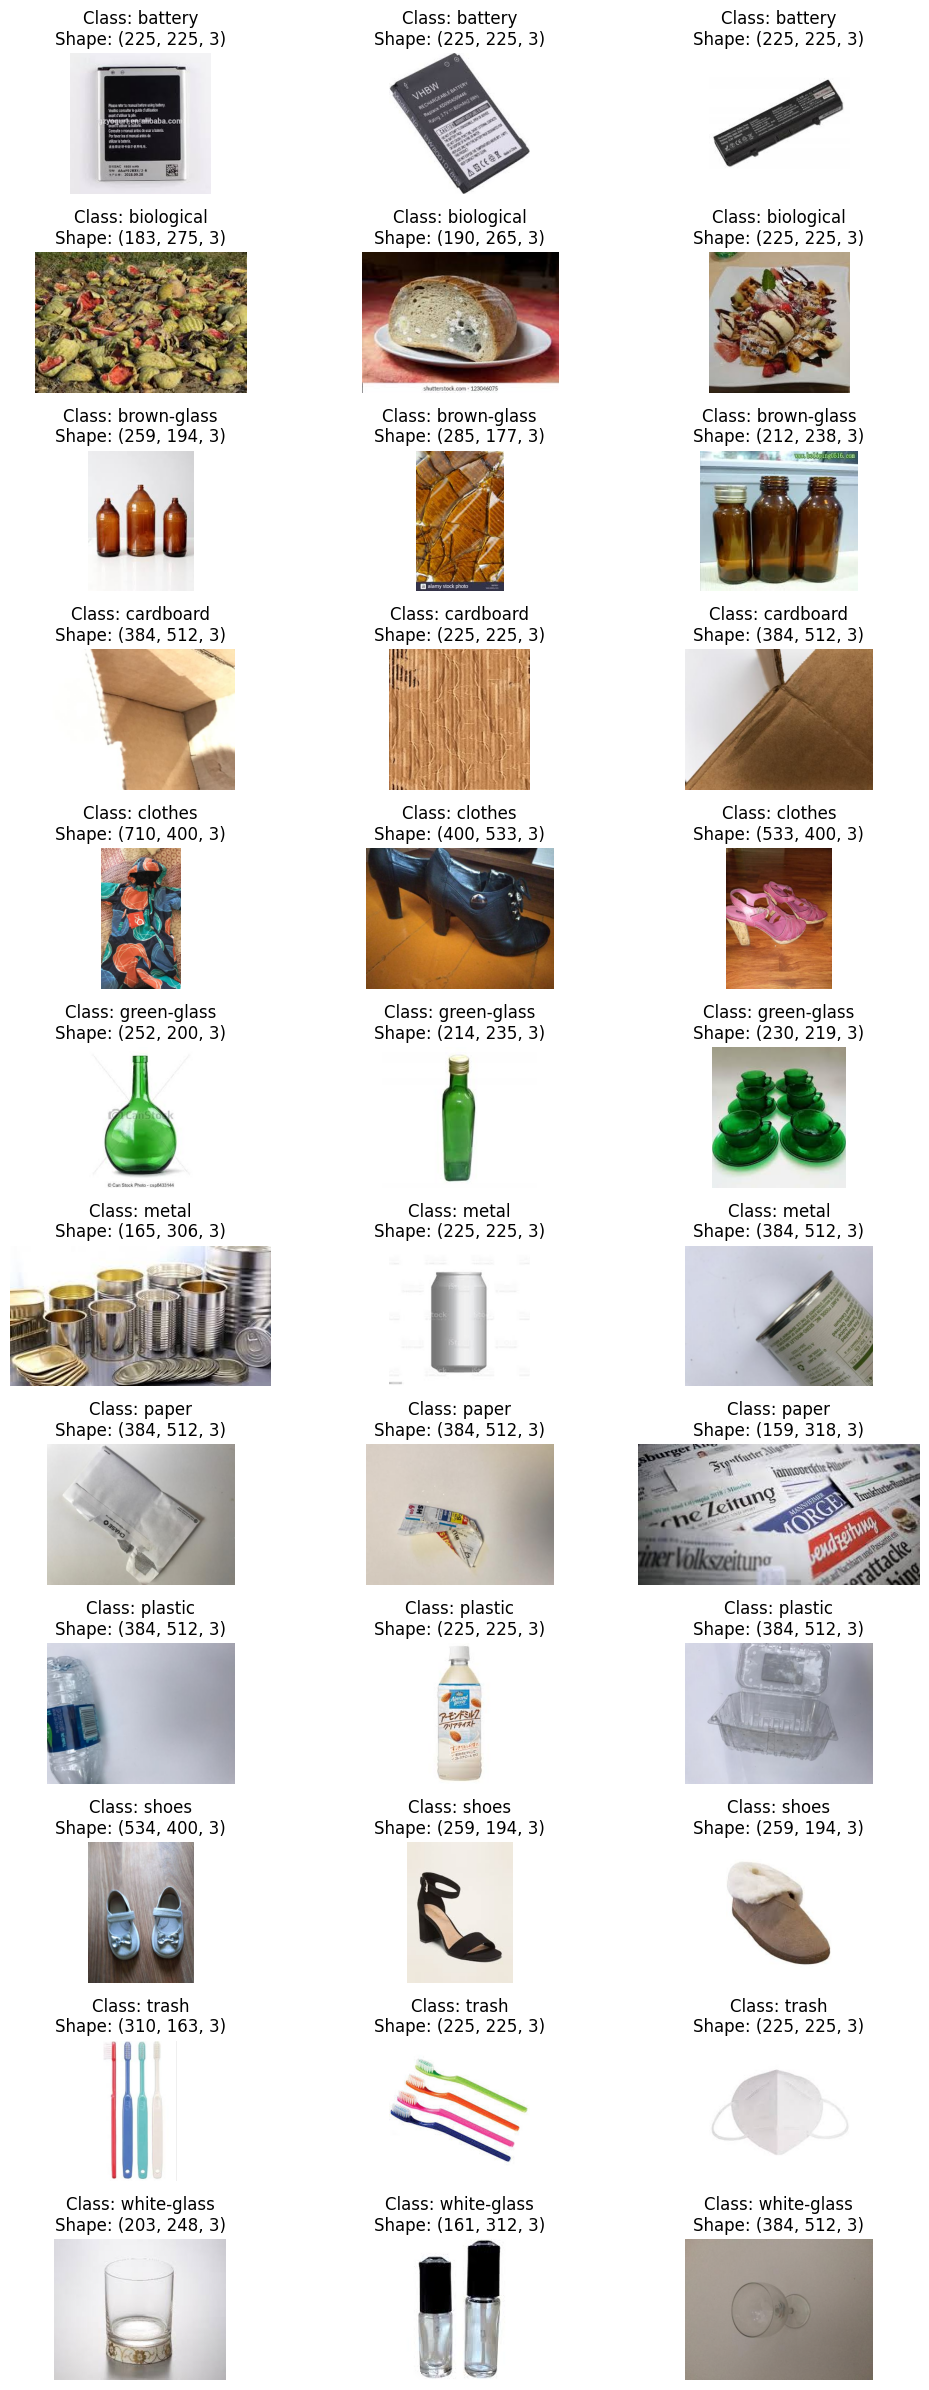

In [5]:
# We view some images per class.
NUM_IMAGES = 3

fig, ax = plt.subplots(nrows = len(classes), 
                       ncols = NUM_IMAGES, 
                       figsize = (10, 24))

p = 0
for c in classes:
    imgs_total = list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg"))
    imgs_selected = random.choices(imgs_total, k = NUM_IMAGES)
    
    for i,img_select in enumerate(imgs_selected):
        img_bgr = cv2.imread(str(img_select))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}")
        ax[p,i].axis("off")
        
    p += 1
    
fig.tight_layout()
fig.show()

# **4. Preprocessing**

We create a dataframe where we store the paths and labels of the images.

In [7]:
data = pd.DataFrame()
path="D:/garbage_classification/"
for category in os.listdir(path):
    temp = pd.DataFrame()
    temp['path'] = np.nan
    temp['target'] = category
    i = 0
    for photo in os.listdir(path+category):
        temp.loc[i, 'path'] = path+category+ "/" + photo
        temp.loc[i, 'filename'] = category+ "/" + photo
        temp.loc[i, 'target'] = category
        i += 1
    data = pd.concat([data, temp], ignore_index=True)
    del temp

In [4]:
data

,path,target,filename
0,D:/garbage_classification/battery/battery1.jpg,battery,battery/battery1.jpg
1,D:/garbage_classification/battery/battery10.jpg,battery,battery/battery10.jpg
2,D:/garbage_classification/battery/battery100.jpg,battery,battery/battery100.jpg
3,D:/garbage_classification/battery/battery101.jpg,battery,battery/battery101.jpg
4,D:/garbage_classification/battery/battery102.jpg,battery,battery/battery102.jpg
...,...,...,...
15510,D:/garbage_classification/white-glass/white-gl...,white-glass,white-glass/white-glass95.jpg
15511,D:/garbage_classification/white-glass/white-gl...,white-glass,white-glass/white-glass96.jpg
15512,D:/garbage_classification/white-glass/white-gl...,white-glass,white-glass/white-glass97.jpg
15513,D:/garbage_classification/white-glass/white-gl...,white-glass,white-glass/white-glass98.jpg


Split the dataframe into 3 sets of images:

- **`Train = 70%`**
- **`Valid = 15%`**
- **`Test = 15%`**

In [8]:
# We define the random seed for reproducibility.
SEED = 123

df_train, df_rest = train_test_split(df_path_label, 
                                     test_size = 0.3, 
                                     random_state = SEED, 
                                     shuffle = True, 
                                     stratify = df_path_label["label"])

df_valid, df_test = train_test_split(df_rest, 
                                     test_size = 0.5, 
                                     random_state = SEED, 
                                     shuffle = True, 
                                     stratify = df_rest["label"])

In [9]:
Counter(df_train["label"])

Counter({'clothes': 3727,
         'paper': 735,
         'brown-glass': 425,
         'shoes': 1384,
         'battery': 661,
         'trash': 488,
         'green-glass': 440,
         'biological': 689,
         'plastic': 606,
         'white-glass': 543,
         'metal': 538,
         'cardboard': 624})

In [10]:
Counter(df_valid["label"])

Counter({'clothes': 799,
         'battery': 142,
         'green-glass': 95,
         'shoes': 296,
         'paper': 157,
         'trash': 105,
         'brown-glass': 91,
         'cardboard': 133,
         'plastic': 129,
         'metal': 116,
         'biological': 148,
         'white-glass': 116})

In [11]:
Counter(df_test["label"])

Counter({'white-glass': 116,
         'shoes': 297,
         'clothes': 799,
         'trash': 104,
         'biological': 148,
         'metal': 115,
         'battery': 142,
         'cardboard': 134,
         'paper': 158,
         'green-glass': 94,
         'plastic': 130,
         'brown-glass': 91})

### Now we have to define the mapping to convert the labels to numbers.

In [12]:
label_map = dict(zip(classes, range(0, len(classes))))
label_map

{'battery': 0,
 'biological': 1,
 'brown-glass': 2,
 'cardboard': 3,
 'clothes': 4,
 'green-glass': 5,
 'metal': 6,
 'paper': 7,
 'plastic': 8,
 'shoes': 9,
 'trash': 10,
 'white-glass': 11}

We apply the mapping.

In [13]:
df_train["label"] = df_train["label"].map(label_map)
df_valid["label"] = df_valid["label"].map(label_map)

Well, it is always good to reset the index, so as not to have any problems.

In [14]:
df_train = df_train.reset_index(drop = True)
df_valid = df_valid.reset_index(drop = True)

# Model

In [15]:
# Shape of EfficientNetB0
im_shape = (180, 180)
batch_size = 32
seed = 42

### Image Augmentation

**Image augmentation** is a technique of applying different transformations to original images which results in multiple transformed copies of the same image. These image augmentation techniques not only expand the size of your dataset but also incorporate a level of variation in the dataset which allows your model to generalize better on unseen data. Keras **ImageDataGenerator** class provides a quick and easy way to augment the images. It provides a host of different augmentation techniques like standardization, rotation, shifts, flips, brightness change, and many more. It is designed to provide real-time data augmentation. Meaning it is generating augmented images on the fly while your model is still in the training stage. ImageDataGenerator class ensures that the model receives new variations of the images at each epoch.

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

Splitting the dataset into training, testing and validation.

In [17]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(data, test_size=0.2, random_state=42)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=42)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

len(df_train), len(df_valid), len(df_test)

(12412, 1551, 1552)

Using ImageDataGenerator on training, testing and validation dataset.

In [19]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=df_train,
    directory=path,
    x_col='filename',
    y_col='target',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 12412 validated image filenames belonging to 12 classes.


In [20]:
val_generator = data_generator.flow_from_dataframe(
    dataframe=df_valid,
    directory=path,
    x_col='filename',
    y_col='target',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 1551 validated image filenames belonging to 12 classes.


In [21]:
test_generator = data_generator.flow_from_dataframe(
    dataframe=df_test,
    directory=path,
    x_col='filename',
    y_col='target',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 1552 validated image filenames belonging to 12 classes.


In [22]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


### EfficientNetB0

**Transfer Learning** is a machine learning method where we reuse a pre-trained model as the starting point for a model on a new task. To put it simply—a model trained on one task is repurposed on a second, related task as an optimization that allows rapid progress when modeling the second task. By applying transfer learning to a new task, one can achieve significantly higher performance than training with only a small amount of data.

**EfficientNet-B0** is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 180-by-180.

In [23]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
'''
Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
We flatten the output of the convolutional layers to create a single long feature vector. 
And it is connected to the final classification model, which is called a fully-connected layer.
'''
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False

# model.summary()

optimizer = Adam()
'''
Optimizers are Classes or methods used to change the attributes of the model such as weights and learning rate 
in order to reduce the losses. Optimizers help to get results faster.
'''
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

epochs = 10

#Callback to save the best model
callbacks_list = [
    ModelCheckpoint(filepath='model_EfficientnetB0_10.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/10


387/387 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.9052
Epoch 1: val_loss improved from inf to 0.21836, saving model to model_EfficientnetB0_10.h5
387/387 [==============================] - 352s 883ms/step - loss: 0.3026 - accuracy: 0.9052 - val_loss: 0.2184 - val_accuracy: 0.9303
Epoch 2/10
387/387 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9820
Epoch 2: val_loss did not improve from 0.21836
387/387 [==============================] - 223s 577ms/step - loss: 0.0600 - accuracy: 0.9820 - val_loss: 0.2875 - val_accuracy: 0.9277
Epoch 3/10
387/387 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9893
Epoch 3: val_loss did not improve from 0.21836
387/387 [==============================] - 223s 575ms/step - loss: 0.0319 - accuracy: 0.9893 - val_loss: 0.2545 - val_accuracy: 0.9375
Epoch 4/10
387/387 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9912
Epoch 4: val_loss did no

# Prediction and Accuracy

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
cm

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

1552/1552 [==============================] - 70s 43ms/step
Classification Report
              precision    recall  f1-score   support

     battery       0.91      0.98      0.95       107
  biological       0.97      1.00      0.99        76
 brown-glass       0.90      0.84      0.87        63
   cardboard       0.96      0.89      0.92        98
     clothes       0.99      0.99      0.99       539
 green-glass       0.93      0.96      0.94        68
       metal       0.93      0.70      0.80        79
       paper       0.92      0.93      0.92       120
     plastic       0.70      0.91      0.79        88
       shoes       0.97      0.98      0.97       181
       trash       0.94      0.97      0.95        65
 white-glass       0.86      0.71      0.77        68

    accuracy                           0.94      1552
   macro avg       0.91      0.90      0.91      1552
weighted avg       0.94      0.94      0.94      1552



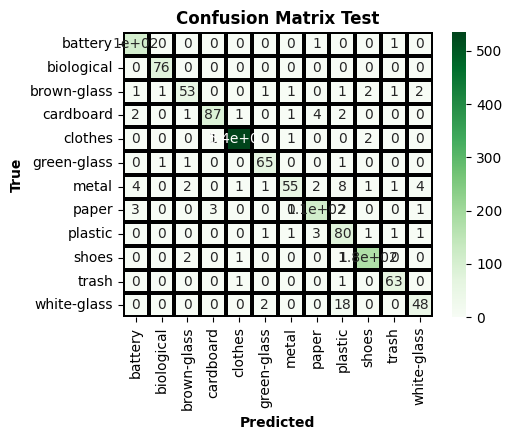

In [28]:
# We visualize the confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig,ax = plt.subplots(figsize=(5,3.7))
sns.heatmap(cm, 
            cmap = "Greens", 
            annot = True, 
            linewidths = 1.5,
            linecolor = "black",
            xticklabels = classes, 
            yticklabels = classes,
            ax = ax)

ax.set_title("Confusion Matrix Test", fontsize = 12, fontweight = "bold", color = "black")
ax.set_xlabel("Predicted", fontsize = 10, fontweight = "bold", color = "black")
ax.set_ylabel("True", fontsize = 10, fontweight = "bold", color = "black")
fig.show()

- **Accuracy**

In [29]:
print(f"Accuracy: {accuracy_score(test_generator.classes, y_pred)}")

Accuracy: 0.9375


**Precision** is one indicator of a machine learning model's performance – the quality of a positive prediction made by the model. 
The **recall** is the measure of our model correctly identifying True Positives.
**F1 Score** is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. 


In [30]:
cm

array([[105,   0,   0,   0,   0,   0,   0,   1,   0,   0,   1,   0],
       [  0,  76,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   1,  53,   0,   0,   1,   1,   0,   1,   2,   1,   2],
       [  2,   0,   1,  87,   1,   0,   1,   4,   2,   0,   0,   0],
       [  0,   0,   0,   1, 535,   0,   1,   0,   0,   2,   0,   0],
       [  0,   1,   1,   0,   0,  65,   0,   0,   1,   0,   0,   0],
       [  4,   0,   2,   0,   1,   1,  55,   2,   8,   1,   1,   4],
       [  3,   0,   0,   3,   0,   0,   0, 111,   2,   0,   0,   1],
       [  0,   0,   0,   0,   0,   1,   1,   3,  80,   1,   1,   1],
       [  0,   0,   2,   0,   1,   0,   0,   0,   1, 177,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   1,   0,  63,   0],
       [  0,   0,   0,   0,   0,   2,   0,   0,  18,   0,   0,  48]],
      dtype=int64)